Mass is conserved. 



--------------------------------------------------
Performing fitting using scikit machine learning algorithms:
--------------------------------------------------
-Using Algorithm: Random Forest Regressor:

The Model Mean Squared Errors: 
 [6.69161877e+00 6.59962856e-18 0.00000000e+00 6.59185107e+10
 6.61438298e+16 6.50060419e-04 6.52550309e-12 0.00000000e+00]

 Initial guess: 

-> Rate Constants:
 [2.00e+00 6.65e-09 2.31e+02 1.15e+05 6.13e+08 2.14e-02 2.85e-06 5.00e+02]

 Final predictions: 

-> Rate Constants:
 [4.29571457e+00 4.50381535e-09 9.00000000e+02 4.27236100e+05
 4.60283681e+08 4.34918635e-02 4.40196319e-06 9.00000000e+02]


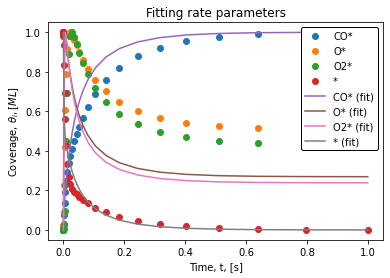

In [1]:
%%time
from main import *
import numpy as np
import matplotlib.pyplot as plt
import sys, os


fit = Fitting('coverages.csv','Atomic.csv','Stoich.csv','Param_Guess.csv',CovgDep=False)
# MLPRegressor
# KNeighborsRegressor
# DecisionTreeRegressor
# RandomForestRegressor
vec = np.array([2.0e0,6.65e-9,2.31e2,1.15e5,6.13e8,2.14e-2,2.85e-6,5.0e2])
fit.k = vec
t,covg,fits = fit.fitting_rate_param(option='ML',mdl='RandomForestRegressor',n=5e4,maxiter=25,maxfun=1e2,plot=True,weight=1e-1)
# print(fit.k)
fit.k = fit.fitted_k 

In [2]:
pip install autograd

Note: you may need to restart the kernel to use updated packages.


In [5]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need

def tanh(x):                 # Define a function
    y = np.exp(-2.0 * x)
    return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)       # Obtain its gradient function
grad_tanh(1.0)           

ImportError: cannot import name 'grad' from 'autograd' (/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/autograd/__init__.py)

In [6]:

from __future__ import absolute_import
from __future__ import print_function
from builtins import range
from os.path import dirname, join
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.scipy.special import logsumexp

from autograd.misc.optimizers import adam
from rnn import string_to_one_hot, one_hot_to_string,\
                build_dataset, sigmoid, concat_and_multiply


def init_lstm_params(input_size, state_size, output_size,
                     param_scale=0.01, rs=npr.RandomState(0)):
    def rp(*shape):
        return rs.randn(*shape) * param_scale

    return {'init cells':   rp(1, state_size),
            'init hiddens': rp(1, state_size),
            'change':       rp(input_size + state_size + 1, state_size),
            'forget':       rp(input_size + state_size + 1, state_size),
            'ingate':       rp(input_size + state_size + 1, state_size),
            'outgate':      rp(input_size + state_size + 1, state_size),
            'predict':      rp(state_size + 1, output_size)}

def lstm_predict(params, inputs):
    def update_lstm(input, hiddens, cells):
        change  = np.tanh(concat_and_multiply(params['change'], input, hiddens))
        forget  = sigmoid(concat_and_multiply(params['forget'], input, hiddens))
        ingate  = sigmoid(concat_and_multiply(params['ingate'], input, hiddens))
        outgate = sigmoid(concat_and_multiply(params['outgate'], input, hiddens))
        cells   = cells * forget + ingate * change
        hiddens = outgate * np.tanh(cells)
        return hiddens, cells

    def hiddens_to_output_probs(hiddens):
        output = concat_and_multiply(params['predict'], hiddens)
        return output - logsumexp(output, axis=1, keepdims=True) # Normalize log-probs.

    num_sequences = inputs.shape[1]
    hiddens = np.repeat(params['init hiddens'], num_sequences, axis=0)
    cells   = np.repeat(params['init cells'],   num_sequences, axis=0)

    output = [hiddens_to_output_probs(hiddens)]
    for input in inputs:  # Iterate over time steps.
        hiddens, cells = update_lstm(input, hiddens, cells)
        output.append(hiddens_to_output_probs(hiddens))
    return output

def lstm_log_likelihood(params, inputs, targets):
    logprobs = lstm_predict(params, inputs)
    loglik = 0.0
    num_time_steps, num_examples, _ = inputs.shape
    for t in range(num_time_steps):
        loglik += np.sum(logprobs[t] * targets[t])
    return loglik / (num_time_steps * num_examples)


if __name__ == '__main__':
    num_chars = 128

    # Learn to predict our own source code.
    text_filename = join(dirname(__file__), 'lstm.py')
    train_inputs = build_dataset(text_filename, sequence_length=30,
                                 alphabet_size=num_chars, max_lines=60)

    init_params = init_lstm_params(input_size=128, output_size=128,
                                   state_size=40, param_scale=0.01)

    def print_training_prediction(weights):
        print("Training text                         Predicted text")
        logprobs = np.asarray(lstm_predict(weights, train_inputs))
        for t in range(logprobs.shape[1]):
            training_text  = one_hot_to_string(train_inputs[:,t,:])
            predicted_text = one_hot_to_string(logprobs[:,t,:])
            print(training_text.replace('\n', ' ') + "|" +
                  predicted_text.replace('\n', ' '))

    def training_loss(params, iter):
        return -lstm_log_likelihood(params, train_inputs, train_inputs)

    def callback(weights, iter, gradient):
        if iter % 10 == 0:
            print("Iteration", iter, "Train loss:", training_loss(weights, 0))
            print_training_prediction(weights)

    # Build gradient of loss function using autograd.
    training_loss_grad = grad(training_loss)

    print("Training LSTM...")
    trained_params = adam(training_loss_grad, init_params, step_size=0.1,
                          num_iters=1000, callback=callback)

    print()
    print("Generating text from LSTM...")
    num_letters = 30
    for t in range(20):
        text = ""
        for i in range(num_letters):
            seqs = string_to_one_hot(text, num_chars)[:, np.newaxis, :]
            logprobs = lstm_predict(trained_params, seqs)[-1].ravel()
            text += chr(npr.choice(len(logprobs), p=np.exp(logprobs)))
        print(text)
Footer


ImportError: cannot import name 'grad' from 'autograd' (/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/autograd/__init__.py)

Mass is conserved. 



--------------------------------------------------
Performing fitting using optimize.minimize:
--------------------------------------------------
-Using Method: L-BFGS-B

 Initial guess: 

-> Rate Constants:
 [1.e+00 1.e-09 1.e+02 1.e+05 1.e+08 1.e-02 1.e-06 1.e+02]

 Final predictions: 

-> Rate Constants:
 [1.00074367e+00 5.81805836e-07 9.99989127e+01 1.00000000e+05
 1.00000000e+08 3.65048530e-02 4.96935286e-06 9.99986210e+01]


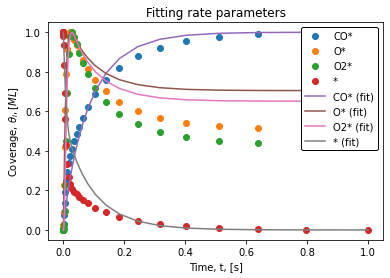

In [2]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
import sys, os

fit = Fitting('coverages.csv','Atomic.csv','Stoich.csv','Param_Guess.csv',CovgDep=False)
# MLPRegressor
# KNeighborsRegressor
# DecisionTreeRegressor
# RandomForestRegressor
t,covg,fits = fit.fitting_rate_param(option='min',method_min='L-BFGS-B',mdl='RandomForestRegressor',n=5e4,gtol=1e-10,maxiter=1e6,maxfun=1e6,plot=True,weight=1e-1)
# print(fit.k)
fit.k = fit.fitted_k 
# sol,solt = fit.solve_coverage(plot=True)